In [2]:
import tensorflow as tf
import os

2023-10-04 11:31:43.324352: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-04 11:31:43.782681: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-04 11:31:43.782727: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-04 11:31:43.785023: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-04 11:31:44.022184: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-04 11:31:44.024800: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [ ]:
images = tf.data.Dataset.list_files("data/train/*.jpg", shuffle=False)

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)
        

In [8]:
train_images = tf.data.Dataset.list_files(os.path.join('data', 'train', 'images', '*.jpg'), shuffle=False)

In [9]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.image.decode_jpeg(byte_img)
    return img


In [10]:
train_images = train_images.map(load_image)

## Augmenting Images

In [11]:
import albumentations as alb

In [12]:
augmentor = alb.Compose([
    # alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5),
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [13]:
import cv2
import matplotlib.pyplot as plt
import json

In [14]:
img = cv2.imread(os.path.join('data', 'train', 'images', '9faaf496-60bf-11ee-8d40-2cdb0706111a.jpg'))

with open(os.path.join('data', 'train', 'labels', '9faaf496-60bf-11ee-8d40-2cdb0706111a.json'), 'r') as f:
    label = json.load(f)

label['shapes'][0]['points']

[[321.01010101010104, 108.18181818181817],
 [523.0303030303031, 371.8181818181818]]

In [15]:
coords = [0, 0, 0, 0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [16]:
import numpy as np

In [17]:
coords = list(np.divide(coords, [640, 480, 640, 480]))

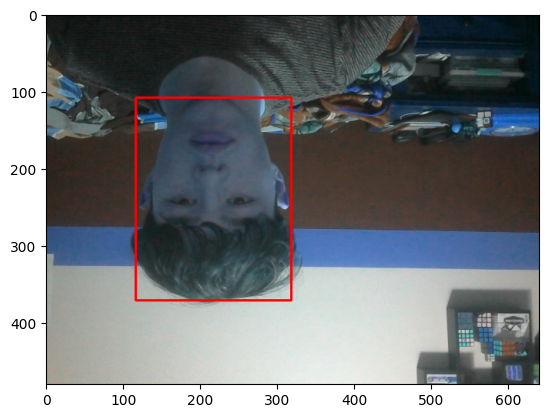

In [18]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
augmented['bboxes']

cv2.rectangle(augmented['image'], tuple(np.multiply(augmented['bboxes'][0][:2], [640, 480]).astype(int)),
                                  tuple(np.multiply(augmented['bboxes'][0][2:], [640, 480]).astype(int)), 
                                  (255, 0, 0), 2)

plt.imshow(augmented['image'])

In [19]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640, 480, 640, 480]))

        try: 
            for x in range(20):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

KeyboardInterrupt: 

## Loading Train, Test, and Val Images

In [20]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
# train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [21]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
# test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [22]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
# val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

## Loading Train, Test, and Val Labels

In [23]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [24]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [25]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [26]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [27]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(1260, 1260, 280, 280, 260, 260)

## Loading Images and Labels into Tensorflow Datasets

In [28]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [29]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [30]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [31]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.09143, 0.2314 , 0.3352 , 0.6177 ],
        [0.3682 , 0.0824 , 0.903  , 0.992  ],
        [0.00258, 0.2544 , 0.3308 , 0.8467 ],
        [0.4685 , 0.01357, 0.986  , 0.8926 ],
        [0.1465 , 0.1732 , 0.5117 , 0.764  ],
        [0.3223 , 0.3748 , 0.5503 , 0.7607 ],
        [0.3352 , 0.08813, 0.857  , 0.9863 ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

In [32]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


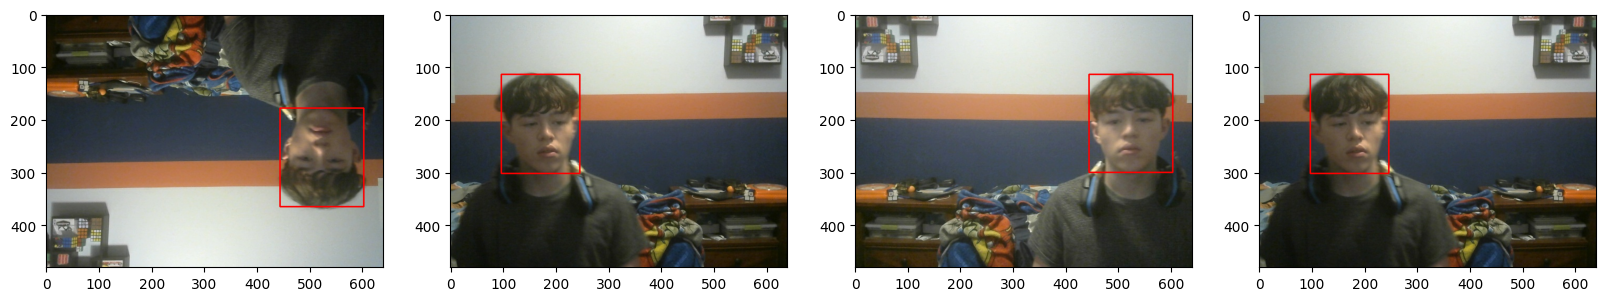

In [34]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [640, 480]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [640, 480]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

## Creating Model

In [37]:
from tensorflow import keras
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), input_shape=(480, 640, 3)),
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='sigmoid')
])

In [38]:
model.compile(optimizer='adam', loss='mse')

In [39]:
model.fit(train, epochs=1)